# London Santander Cycle Hire

Exploratory analysis of London's Santander Cycle Hire Scheme data.

<p align="center"> 
<img src="alessandra-caretto-bicycle.jpg">
</p>
<p align="center">
Credit: Photo by Alessandra Caretto on Unsplash.
</p>

### Introduction

Santander Cycles is a public bicycle hire scheme in London, United Kingdom. The scheme's bicycles are most popularly known as Boris Bikes, after then-Mayor of London, Boris Johnson, who introduced them during his tenure. The success of the hire scheme can be measured in many ways, easing the strain on the public transport system; getting Londoners active and fit, and good old-fashioned fun. 

Maintaining many bicycles is difficult, how can data help us? 

In this article we will answer the following questions:
- How many kilometers are travelled per month (as the crow flies)?
- How many kilometers does the average bike travel in a year (as the crow flies)? <br>
- Which location is most popular? <br>
- What is special about the popular locations?

This data is publicly available through Google's BigQuery. Data includes start and stop timestamps, station names and ride duration. BigQuery is serverless, highly scalable, and cost-effective cloud data warehouse designed for business agility and provides 1TB of free queries per month. In the following analyses we will focus on the year 2016.

In [2]:
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

import googlemaps
from google.cloud import bigquery

import matplotlib.pyplot as plt

client = bigquery.Client(
    project='slackbot-staging'
)

def print_table_metadata(table):
    table_metadata = client.get_table(table)
    table_size = round(table_metadata.num_bytes / (2**30),2)
    row_count = format(table_metadata.num_rows,  ",")

    print(f'''The table {table_metadata.table_id} has {row_count} rows and is {table_size} GB.''')

print_table_metadata('bigquery-public-data.london_bicycles.cycle_hire')
print_table_metadata('bigquery-public-data.london_bicycles.cycle_stations')

The table cycle_hire has 24,369,201 rows and is 2.59 GB.
The table cycle_stations has 777 rows and is 0.0 GB.


In [3]:
# Note: this table is not partitioned
query = """
    select * 
    from bigquery-public-data.london_bicycles.cycle_hire 
    limit 3
"""
df = client.query(query).to_dataframe()
df.head(3)

,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name,end_station_logical_terminal,start_station_logical_terminal,end_station_priority_id
0,47469109,3180,7054,2015-09-03 12:45:00+00:00,111,"Park Lane , Hyde Park",2015-09-03 11:52:00+00:00,300,"Serpentine Car Park, Hyde Park",None,None,None
1,46915469,7380,3792,2015-08-16 11:59:00+00:00,407,"Speakers' Corner 1, Hyde Park",2015-08-16 09:56:00+00:00,407,"Speakers' Corner 1, Hyde Park",None,None,None
2,65899423,2040,3038,2017-06-09 18:30:00+00:00,165,"Orsett Terrace, Bayswater",2017-06-09 17:56:00+00:00,579,"Queen Street 2, Bank",None,None,None


In [4]:
# Since "cycle_stations" is a much smaller table we will load it into memory.
query = """
    select * 
    from bigquery-public-data.london_bicycles.cycle_stations
"""
df_cycle_stations = client.query(query).to_dataframe()
df_cycle_stations.head(3)

,id,installed,latitude,locked,longitude,name,bikes_count,docks_count,nbEmptyDocks,temporary,terminal_name,install_date,removal_date
0,403,True,51.516893,false,-0.158250,"George Place Mews, Marylebone",0,16,15,False,10630,2011-03-08,None
1,49,True,51.507069,false,-0.145904,"Curzon Street, Mayfair",0,16,16,False,3437,2010-07-10,None
2,306,True,51.518163,false,-0.135026,"Rathbone Street, Fitzrovia",0,16,16,False,3497,2010-07-22,None


In [5]:
df_popular_stations = None # free up memory

query = '''
select
    timestamp_trunc(start_date, month) as start_month
    , sum(
        st_distance(
            st_geogpoint(start_loc.longitude, start_loc.latitude),
            st_geogpoint(end_loc.longitude, end_loc.latitude)
        )
      ) as total_distance
from 
    `bigquery-public-data.london_bicycles.cycle_hire` hires
left join
    `bigquery-public-data.london_bicycles.cycle_stations` start_loc on start_loc.id = hires.start_station_id
left join
    `bigquery-public-data.london_bicycles.cycle_stations` end_loc on end_loc.id = hires.end_station_id
where timestamp_trunc(start_date, year) = '2016-01-01'
group by 1
order by 1
'''

df_distance_travelled = client.query(query).to_dataframe()
df_distance_travelled.head(3)

,start_month,total_distance
0,2016-01-01 00:00:00+00:00,1.151819e+09
1,2016-02-01 00:00:00+00:00,1.166414e+09
2,2016-03-01 00:00:00+00:00,1.283905e+09


Text(0.5, 1.0, 'Distance by month in 2016')

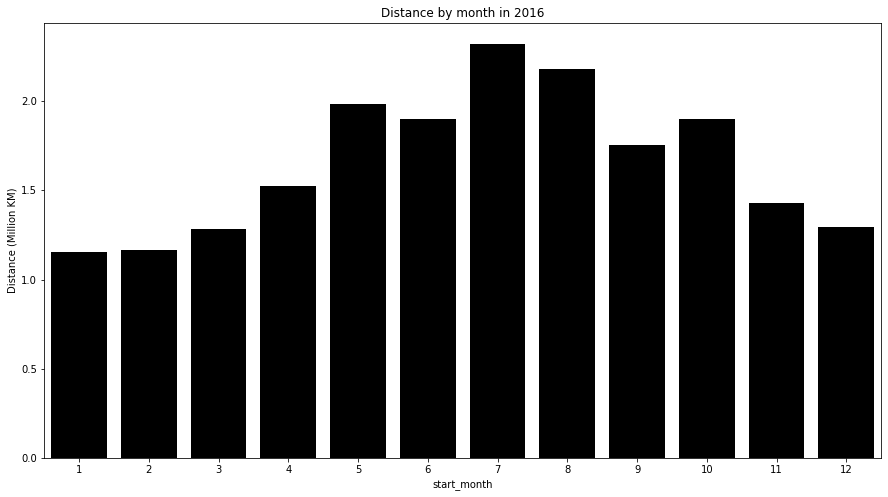

In [6]:
df_distance_travelled['Distance (Million KM)'] = df_distance_travelled.total_distance / 1000000000

plt.figure(figsize=(15,8))
sns.barplot(
    x=df_distance_travelled.start_month.dt.month, 
    y=df_distance_travelled['Distance (Million KM)'],
    color='black',
).set_title('Distance by month in 2016')

### How many kilometers does the average bike travel in a year?

In [7]:
query = '''
select
    bike_id
    , sum(
        st_distance(
            st_geogpoint(start_loc.longitude, start_loc.latitude),
            st_geogpoint(end_loc.longitude, end_loc.latitude)
        )
      ) as total_distance
from 
    `bigquery-public-data.london_bicycles.cycle_hire` hires
left join
    `bigquery-public-data.london_bicycles.cycle_stations` start_loc on start_loc.id = hires.start_station_id
left join
    `bigquery-public-data.london_bicycles.cycle_stations` end_loc on end_loc.id = hires.end_station_id
where timestamp_trunc(start_date, year) = '2016-01-01'
group by bike_id
'''

df_bike_distance = client.query(query).to_dataframe()
df_bike_distance.head(10)

,bike_id,total_distance
0,7183,1.558778e+06
1,7619,1.735466e+06
2,1710,1.534224e+06
3,12290,2.152459e+06
4,11430,1.824374e+06
5,1532,1.801782e+06
6,682,1.914793e+06
7,5099,1.409116e+06
8,2527,1.779991e+06
9,9456,8.201585e+05


In [8]:
df_bike_distance['total_distance_km'] = df_bike_distance.total_distance / 1000
df_bike_distance.describe()

,bike_id,total_distance,total_distance_km
count,12942.000000,1.294100e+04,12941.000000
mean,7563.677561,1.537033e+06,1537.032528
std,4330.951687,4.491114e+05,449.111389
min,1.000000,1.414510e+03,1.414510
25%,3802.250000,1.390164e+06,1390.163721
50%,7609.500000,1.615000e+06,1614.999529
75%,11296.500000,1.808634e+06,1808.633678
max,14841.000000,2.789835e+06,2789.835110


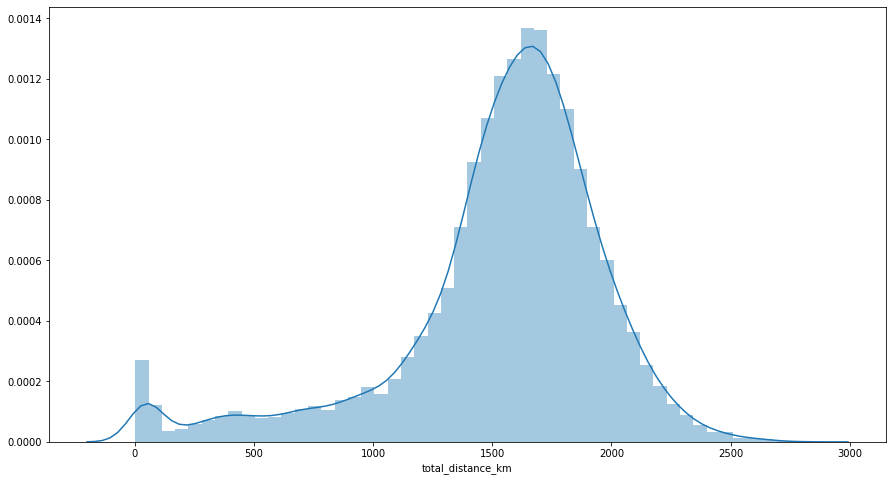

In [9]:
plt.figure(figsize=(15,8))
sns.distplot(df_bike_distance.total_distance_km)

### Which location is most popular?

Below we see that the most popular routes by the number of journeys are near parks, and in particular Hyde Park Corner a leisure spot.


<p align="center"> 
<img height="500px" src="hyde-park-yair-aronshtam.jpg">
</p>
<p align="center">
Credit: Photo by Yair Aronshtam on CreativeCommons.org.
</p>

In [10]:
query = '''
with station_stats as (
    select
        start_station_id
        , end_station_id
        , start_station_name
        , end_station_name
        , count(rental_id) as journeys
    from `bigquery-public-data.london_bicycles.cycle_hire`
    where timestamp_trunc(start_date, year) = '2016-01-01'
    group by 1,2,3,4
)

select
    station_stats.*
    , start_loc.longitude as start_longitude
    , start_loc.latitude as start_latitude
    , end_loc.longitude as end_longitude
    , end_loc.latitude as end_latitude
from 
    station_stats
left join
    `bigquery-public-data.london_bicycles.cycle_stations` start_loc on start_loc.id = station_stats.start_station_id
left join
    `bigquery-public-data.london_bicycles.cycle_stations` end_loc on end_loc.id = station_stats.end_station_id
order by journeys desc
'''

df_popular_routes = client.query(query).to_dataframe()
df_popular_routes[['journeys', 'start_station_name', 'end_station_name']].head(10)

,journeys,start_station_name,end_station_name
0,21229,"Hyde Park Corner, Hyde Park","Hyde Park Corner, Hyde Park"
1,16264,"Aquatic Centre, Queen Elizabeth Olympic Park","Aquatic Centre, Queen Elizabeth Olympic Park"
2,13094,"Albert Gate, Hyde Park","Albert Gate, Hyde Park"
3,12579,"Black Lion Gate, Kensington Gardens","Black Lion Gate, Kensington Gardens"
4,9022,"Triangle Car Park, Hyde Park","Triangle Car Park, Hyde Park"
5,6860,"Podium, Queen Elizabeth Olympic Park","Podium, Queen Elizabeth Olympic Park"
6,5977,"Speakers' Corner 1, Hyde Park","Speakers' Corner 1, Hyde Park"
7,5566,"Speakers' Corner 2, Hyde Park","Speakers' Corner 2, Hyde Park"
8,5495,"Palace Gate, Kensington Gardens","Palace Gate, Kensington Gardens"
9,5233,"Wellington Arch, Hyde Park","Wellington Arch, Hyde Park"


In [11]:
fig = px.density_mapbox(df_popular_routes.head(10), lat='start_latitude', lon='start_longitude', z='journeys', radius=10,
                        center=dict(lat=51.5, lon=-0.11), zoom=10,
                        mapbox_style="stamen-terrain", title="Sample of top starting Locations")
fig.show()

### What is special about the popular locations?

In this section we will use the Google Maps API to understand more about popular locations.

In [18]:
top_100 = df_popular_routes.head(100).start_station_name.tolist()
responses = {}

gmaps = googlemaps.Client(key='')

for location in top_100:
    location_data = gmaps.places(location)
    responses[location] = location_data

Using the Google Places API we can get rich metadata, for our analyses we will look at the type of the top 100 locations. 

In [32]:
pd_dict = {
    'location': [],
    'rating': [],
    'types': []
}

for key in responses.keys():
    pd_dict['location'].append(key)
    if not responses[key].get('status') == 'ZERO_RESULTS':
        pd_dict['rating'].append(responses[location]['results'][0].get('rating'))
        pd_dict['types'].append(responses[key]['results'][0].get('types')[0])
    else:
        pd_dict['rating'].append(None)
        pd_dict['types'].append(None)

df = pd.DataFrame(pd_dict)

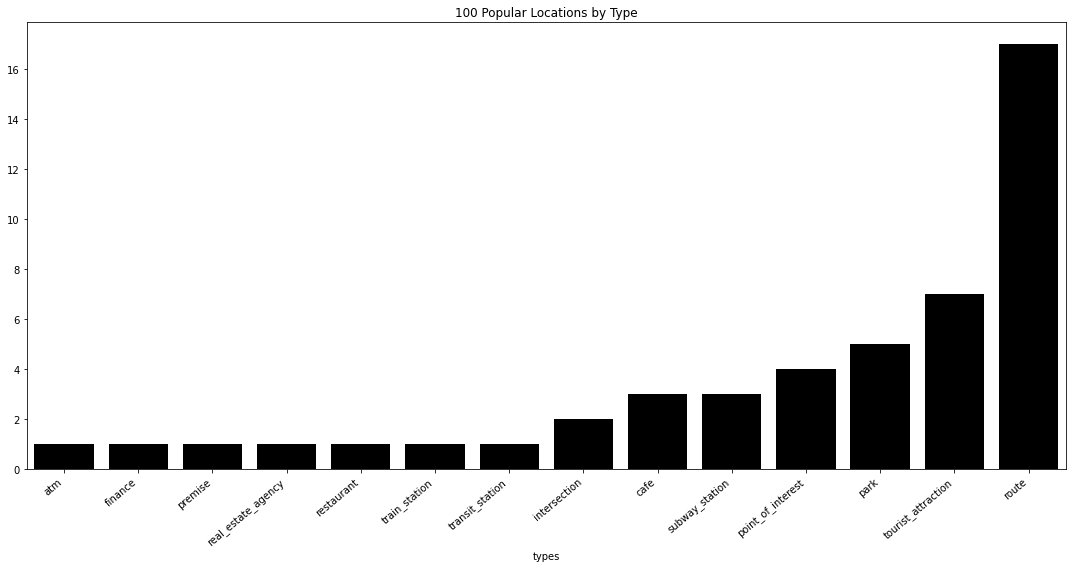

In [33]:
plt.figure(figsize=(15,8))

df_type = df.groupby('types')['location'].count().sort_values()
ax = sns.barplot(
    x=df_type.index, 
    y=df_type.values,
    color='black',
)

ax.set_title('100 Popular Locations by Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

### Conclusion

- July is the busiest month for cycling in London, with some 2 million kilometers being cycled.
- In a single year the average bike travels 1537 kilometers as the crow flies.
- Leisure spots like Hyde Park and the Olympic Stadium are locations people frequently cycle around.
- By combining our dataset with information from the Google Places API we can see the most popular locations are travel routes followed by tourst attractions and parks.
